<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/correlation/folder/Correlation_gold.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import datetime

In [20]:
data = pd.read_csv('/content/gold.csv')

In [21]:
data['date']=data.time.apply(lambda d: datetime.datetime.fromtimestamp(int(d)).strftime('%d-%m-%Y'))

In [22]:
del data['time']

In [23]:
data= data.set_index('date')

In [24]:
data=data['01-01-2018':]

In [25]:
data_subset = data[['close','GOLDBEES, NSE: Close']]

In [26]:
data_subset.tail(2)

,close,"GOLDBEES, NSE: Close"
date,,
29-08-2022,17370.25,43.85
30-08-2022,17827.50,43.90


In [27]:
data_subset.columns=['close','close1']

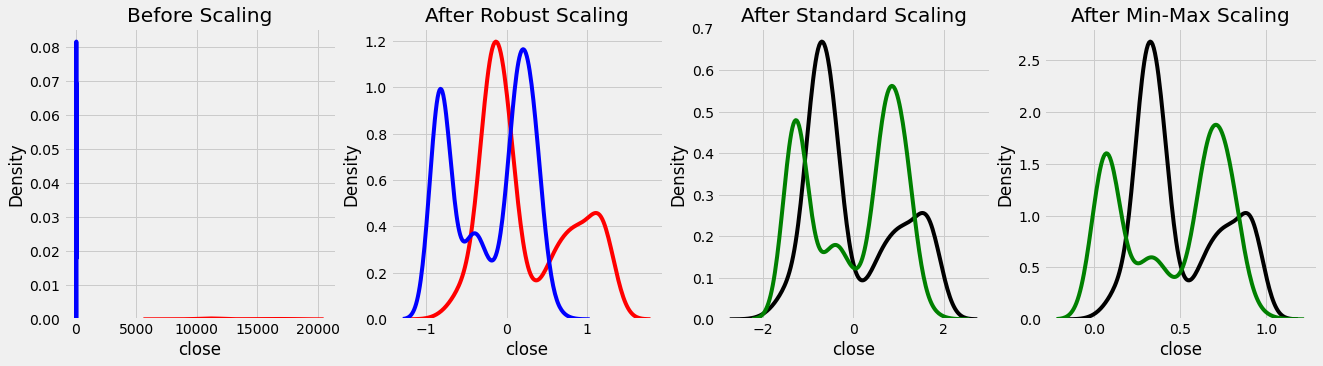

In [28]:
# Importing libraries
from sklearn import preprocessing
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns 
%matplotlib inline
matplotlib.style.use('fivethirtyeight')

# data
x = data_subset
scaler = preprocessing.RobustScaler()
robust_df = scaler.fit_transform(x)
robust_df = pd.DataFrame(robust_df, columns =['close','close1'])

scaler = preprocessing.StandardScaler()
standard_df = scaler.fit_transform(x)
standard_df = pd.DataFrame(standard_df, columns =['close','close1'])

scaler = preprocessing.MinMaxScaler()
minmax_df = scaler.fit_transform(x)
minmax_df = pd.DataFrame(minmax_df, columns =['close','close1'])

fig, (ax1, ax2, ax3, ax4) = plt.subplots(ncols = 4, figsize =(20, 5))
ax1.set_title('Before Scaling')

sns.kdeplot(x['close'], ax = ax1, color ='r')
sns.kdeplot(x['close1'], ax = ax1, color ='b')
ax2.set_title('After Robust Scaling')

sns.kdeplot(robust_df['close'], ax = ax2, color ='red')
sns.kdeplot(robust_df['close1'], ax = ax2, color ='blue')
ax3.set_title('After Standard Scaling')

sns.kdeplot(standard_df['close'], ax = ax3, color ='black')
sns.kdeplot(standard_df['close1'], ax = ax3, color ='g')
ax4.set_title('After Min-Max Scaling')

sns.kdeplot(minmax_df['close'], ax = ax4, color ='black')
sns.kdeplot(minmax_df['close1'], ax = ax4, color ='g')
plt.show()


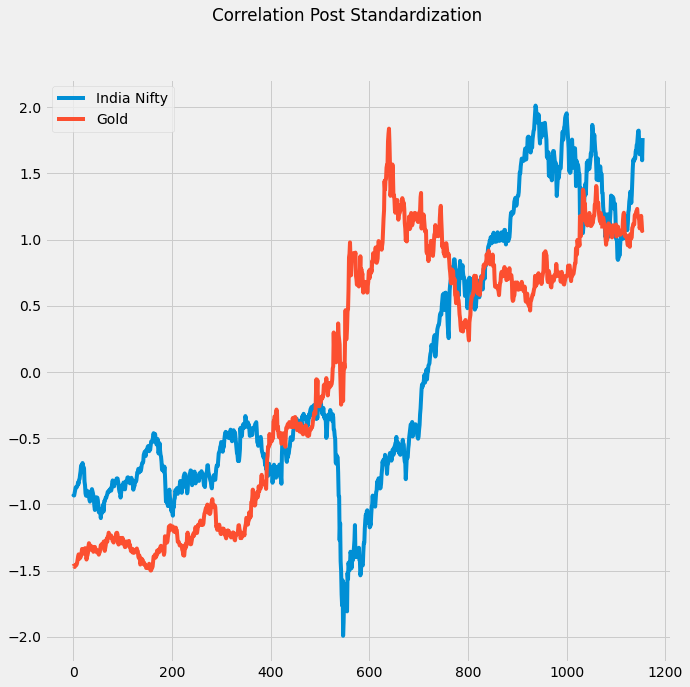

In [29]:
columns=['India Nifty','Gold']
standard_df.columns=columns
standard_df[-1800:].plot(figsize=(10,10))
plt.suptitle('Correlation Post Standardization')
plt.show()

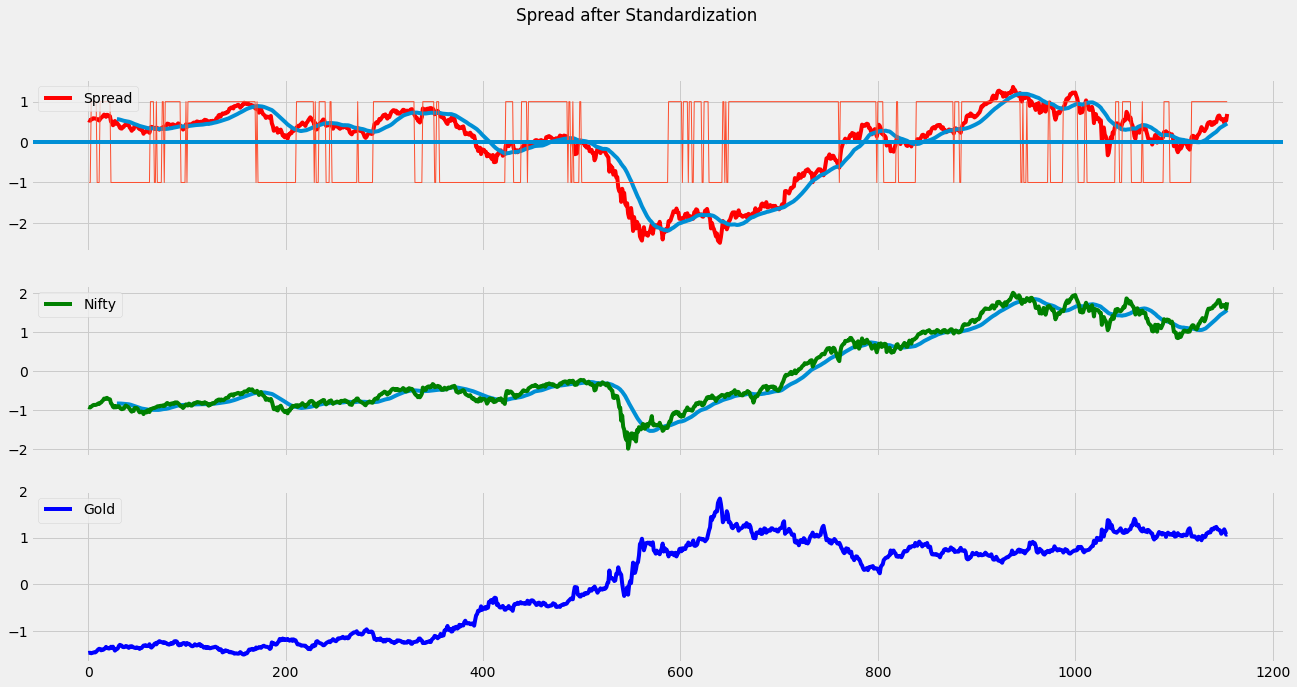

In [35]:
standard_df['diff']=standard_df['India Nifty']-standard_df['Gold']
standard_df['diff']=standard_df['diff'].fillna(method='ffill')
plt.rcParams["figure.figsize"] = (20,10)
fig,ax=plt.subplots(3,1,sharex=True)

ax[0].plot(standard_df['diff'],color='r',label='Spread')
ax[0].plot(standard_df['diff'].rolling(window=30).mean())
ax[0].plot(np.sign(standard_df['diff'].ewm(span=35).mean().diff()),linewidth=1)
ax[1].plot(standard_df['India Nifty'].rolling(window=30).mean())
ax[1].plot(standard_df['India Nifty'],color='g',label='Nifty')
ax[2].plot(standard_df['Gold'],color='b',label='Gold')
ax[0].axhline(y=0)
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
plt.suptitle('Spread after Standardization')
plt.show()

In [ ]:
data_subset['close_pct']=data_subset['close'].pct_change(60)
data_subset['close1_pct']=data_subset['close1'].pct_change(60)

data_subset.dropna(inplace=True)
g=sns.jointplot(x='close_pct',y='close1_pct',data=data_subset,kind='reg').plot_joint(sns.kdeplot,n_levels=6)
r, p = pearsonr(data_subset['close_pct'], data_subset['close1_pct'])
phantom, = g.ax_joint.plot([], [], linestyle="", alpha=0)
g.ax_joint.legend([phantom],['r={:f}, p={:f}'.format(r,p)])
plt.suptitle(f'Correlation for last 60 days is {round(r*100)}%')
plt.show()